In [1]:
import sys; sys.path.insert(0, '..') # So that we import the local copy of pyzx if you have installed from Github
import os

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

from multiprocessing import Pool
import pyzx as zx
from pyzx import cnot_mapper, architecture # Note that this is the local pyzx package from this repository/fork, not the one installed through pip or other means.
from pyzx import circuit
from pyzx import *
from pyzx.parity_maps import CNOT_tracker, build_random_parity_map
from pyzx.linalg import Mat2
from pyzx.simplify import full_reduce

Load comb circuits

In [2]:
comb_circuit_folder = "../circuits/combs/"

circuit_properties = {"Qubits"    : 3,
                      "CNOTs"     : 2,
                      "Non-CNOTs" : 1}
path = os.path.join(comb_circuit_folder, 
                    str(circuit_properties["Qubits"])+"qubits", 
                    str(circuit_properties["CNOTs"])+"cnots", 
                    str(circuit_properties["Non-CNOTs"])+"non-cnots")
loaded_circuits = []
if os.path.exists(path):
    for file_name in os.listdir(path):
        loaded_circuits.append(circuit.Circuit.from_qasm_file(os.path.join(path, file_name)))
else:
    print("Directory Does Not Exist")

In [3]:
def extract_sub_matrix(matrix, index_list):
    new_matrix = Mat2(np.zeros([len(index_list), matrix.cols()], dtype=int))
    for row in range(new_matrix.rows()):
        for col in range(new_matrix.cols()):
            new_matrix.data[row][col] = matrix.data[index_list[row]][col]
    return new_matrix
def insert_sub_matrix(matrix, sub_matrix, index_list):
    for row in range(sub_matrix.rows()):
        for col in range(sub_matrix.cols()):
            matrix.data[index_list[row]][col] = sub_matrix.data[row][col]
    return matrix
def remove_rowcol(matrix, index):
    matrix.data = np.delete(matrix.data, index, 0)
    matrix.data = np.delete(matrix.data, index, 1)
    print(matrix)

In [4]:
def elimination_order(comb):
    #return list(range(comb.qubits))
    
    return [3,2,0,1]

In [12]:
from IPython.display import display, Markdown

DEBUG = False
OUTER_DISPLAY = False
INNTER_DISPLAY = False

#INDEX = 16
for INDEX in range(100):
    circ = loaded_circuits[INDEX].copy()
    OUTER_DISPLAY and display(zx.draw(circ))
    decomposition = CombDecomposition.from_circuit(circ)
    comb = decomposition.comb
    OUTER_DISPLAY and display(zx.draw(comb))
    new_comb = CNOTComb(comb.qubits, comb.holes, comb.new_to_old_qubit_mappings)
    arch = architecture.create_architecture(architecture.LINE, n_qubits=circ.qubits)
    # Create a copy of the parity matrix of the comb to perform gaussian elimination on
    matrix = comb.matrix.copy()


    DEBUG and print(comb.matrix)


    # Find initial qubits for the sub matrix
    qubits_in_matrix = []
    old_to_new_qubits = dict([(i,[]) for i in range(circ.qubits)])
    for virtual_qubit in comb.new_to_old_qubit_mappings.keys():
        old_to_new_qubits[comb.new_to_old_qubit_mappings[virtual_qubit]].append(virtual_qubit)
    for logical_qubit in old_to_new_qubits.keys():
        if len(old_to_new_qubits[logical_qubit]) == 0:
            qubits_in_matrix.append(logical_qubit)
        else:
            qubits_in_matrix.append(max(old_to_new_qubits[logical_qubit]))    

    DEBUG and print(qubits_in_matrix)


    # These are the qubits still accessible on the architecture
    # This doesn't include virtual qubits
    rows_to_eliminate = list(range(circ.qubits))
    cols_to_eliminate = elimination_order(comb)
    while 0 < len(cols_to_eliminate):

        # Generate sub matrix
        sub_matrix = extract_sub_matrix(matrix, qubits_in_matrix)
        sub_circuit = CNOT_tracker(circ.qubits, parities_as_columns=False)
        col_to_eliminate = cols_to_eliminate[0]
        DEBUG and print(comb.holes)
        DEBUG and print(comb.new_to_old_qubit_mappings)

        # Take account of mapping from virtual to logical qubits
        if col_to_eliminate in comb.new_to_old_qubit_mappings:
            row_to_eliminate = comb.new_to_old_qubit_mappings[col_to_eliminate]
        else:
            row_to_eliminate = col_to_eliminate

        DEBUG and print(f"Qubit to eliminate {col_to_eliminate} ({row_to_eliminate})")

        # Remove current rowcol from matrix
        rowcol_iteration(sub_matrix, # need to generate correct sub matrix
                         arch,
                         row_to_eliminate, # rowcol needs to 'see' the virtual qubit as the original
                         col_to_eliminate,
                         rows_to_eliminate, # need to generate list of qubits currently accessible
                         cols_to_eliminate,
                         circuit=sub_circuit)
        DEBUG and print(sub_circuit.gates)

        # Convert the gates of the sub matrix using the mapping
        for gate in sub_circuit.gates[::-1]:
            gate.control = qubits_in_matrix[gate.control]
            gate.target = qubits_in_matrix[gate.target]
            # Add gates from sub circuit to comb circuit
            new_comb.gates.insert(0, gate)
        # Insert submatrix back into larger matrix
        insert_sub_matrix(matrix, sub_matrix, qubits_in_matrix)    

        DEBUG and print(new_comb.gates)


        # If the qubit just removed maps to another qubit via a hole
        # replace that qubit with the new qubit in the qubits_in_matrix list
        qubit_found = False
        qubit_loc = 0
        while not qubit_found:
            qubit = qubits_in_matrix[qubit_loc]
            if qubit == cols_to_eliminate[0]:
                qubit_found = True
                # Remove virtual qubit
                cols_to_eliminate.pop(0)
                # Check if there are anymore virtual qubits that could be assigned to this logical one
                if qubit in comb.holes.inverse.keys():
                    qubits_in_matrix[qubit_loc] = comb.holes.inverse.pop(qubit)
                else:
                    # If no more virtual qubits can be assigned we remove it from being considered
                    # available in the architecture
                    if qubit in comb.new_to_old_qubit_mappings:
                        rows_to_eliminate.remove(comb.new_to_old_qubit_mappings[qubit])
                    else:
                        rows_to_eliminate.remove(qubit)
            qubit_loc += 1

        INNTER_DISPLAY and display(zx.draw(new_comb))      

    decomposition.comb = new_comb
    new_circuit = CombDecomposition.to_circuit(decomposition)
    #print("New Circuit: ")
    print(f"{INDEX} : {new_circuit.verify_equality(loaded_circuits[INDEX])}")
    OUTER_DISPLAY and display(zx.draw(new_circuit))

0 : True
1 : True
2 : True
3 : True
4 : True
5 : True
6 : True
7 : True
8 : True
9 : True
10 : True
11 : True
12 : True
13 : True
14 : True
15 : True
16 : True
17 : True
18 : True
19 : True
20 : True
21 : True
22 : True
23 : True
24 : True
25 : True
26 : True
27 : True
28 : True
29 : True
30 : True
31 : True
32 : True
33 : True
34 : True
35 : True
36 : True
37 : True
38 : True
39 : True
40 : True
41 : True
42 : True
43 : True
44 : True
45 : True
46 : True
47 : True
48 : True
49 : True
50 : True
51 : True
52 : True
53 : True
54 : True
55 : True
56 : True
57 : True
58 : True
59 : True
60 : True
61 : True
62 : True
63 : True
64 : True
65 : True
66 : True
67 : True
68 : True
69 : True
70 : True
71 : True
72 : True
73 : True
74 : True
75 : True
76 : True
77 : True
78 : True
79 : True
80 : True
81 : True
82 : True
83 : True
84 : True
85 : True
86 : True
87 : True
88 : True
89 : True
90 : True
91 : True
92 : True
93 : True
94 : True
95 : True
96 : True
97 : True
98 : True
99 : True


In [6]:
matrix = Mat2(np.array([[1,1,0,1],
                        [0,1,0,0],
                        [0,0,0,1]]))
choice = 0
rowcols_to_eliminate = [0,1,2]
A_inv = matrix.copy().data
A_inv = np.delete(A_inv, choice, 0)
A_inv = np.delete(A_inv, choice, 1)
A_inv = np.linalg.pinv(A_inv)
B = np.array(matrix.data[choice])
B = np.delete(B, choice, 0)
#Mat2([[matrix.data[row][col] for row in rowcols_to_eliminate if row != choice] for col  in rowcols_to_eliminate if col != choice])
print(A_inv)
print(B)
print(B.dot(A_inv))
#print(np.linalg.pinv(matrix.data))

[[1. 0.]
 [0. 0.]
 [0. 1.]]
[1 0 1]
[1. 1.]


In [7]:
np.dot(np.linalg.pinv(matrix.data), matrix.data)

array([[ 1.,  0.,  0.,  0.],
       [-0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.],
       [-0., -0.,  0.,  1.]])

In [8]:
temp = CNOT_tracker(4)

In [9]:
temp.row_add(3,2)
temp.row_add(2,1)
temp.row_add(3,1)
temp.row_add(2,0)
print(temp.gates)

[CNOT(2,0), CNOT(3,1), CNOT(2,1), CNOT(3,2)]


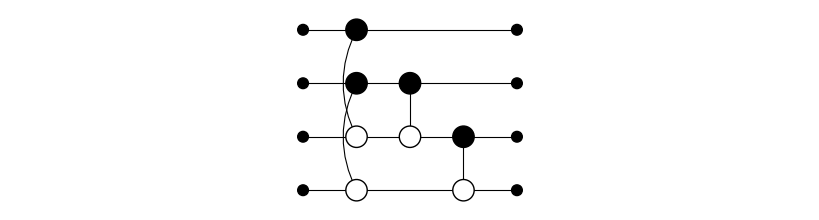

In [10]:
zx.draw(temp)